In [205]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams.update({'font.family': "serif"})
matplotlib.rcParams.update({'mathtext.fontset': "dejavuserif"})
import corner

np.random.seed(1)

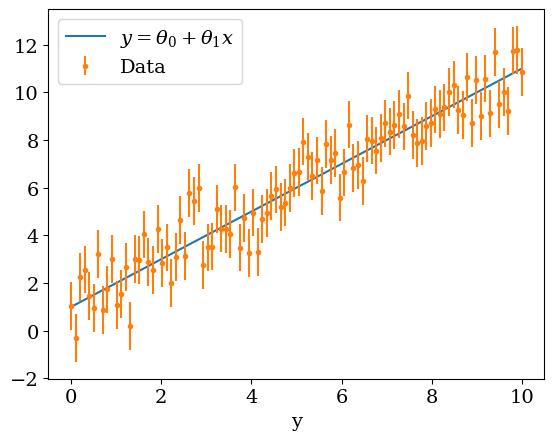

In [196]:
x = np.linspace(0,10, 100)
t0, t1 = 1,1
y = t0 + t1*x
data = y + np.random.normal(0, 1, size=len(y))

plt.plot(x,y, label = r'$y=\theta_0+\theta_1 x$')
plt.errorbar(x,data, 1, fmt='.', label='Data')
plt.xlabel('x')
plt.xlabel('y')
plt.legend()

In [189]:
def likelihood(theta0, theta1, x, y, sigma=1):
    """Gaussian likelihood for linear model."""
    y_pred = theta0 + theta1 * x
    residuals = y - y_pred
    return np.exp(-0.5 * np.sum((residuals / sigma)**2))

def prior(theta0, theta1):
    """Flat prior (constant for all theta)."""
    p0 = 1 if 0 <= theta0 <= 2 else 0
    sigma1 = 0.03
    p1 = np.exp(-0.5 * ((theta1-t1)/sigma1)**2)
    return p0*p1

# Posterior density
def posterior(theta0, theta1, x, y):
    """Posterior density proportional to likelihood * prior."""
    return likelihood(theta0, theta1, x, y) * prior(theta0, theta1)


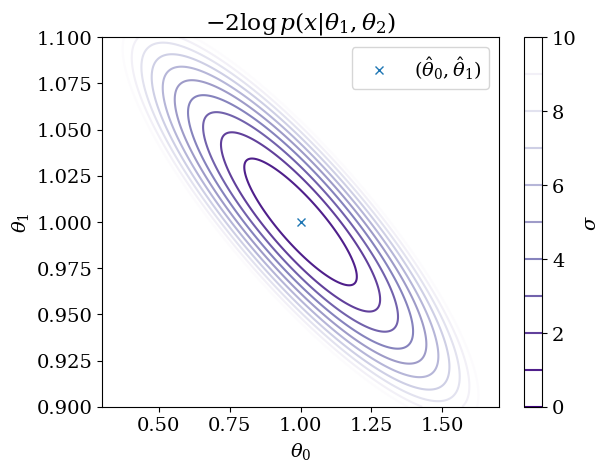

In [197]:
def plot_2d_pdf_contour(pdf_function, x_range=(0.3, 1.7), y_range=(0.9, 1.1), resolution=500):
    x = np.linspace(x_range[0], x_range[1], resolution)
    y = np.linspace(y_range[0], y_range[1], resolution)
    X, Y = np.meshgrid(x, y)

    Z = np.vectorize(lambda x, y: pdf_function(x, y))(X, Y)

    plt.contour(X, Y, Z, cmap='Purples_r', levels=np.arange(0,11,1))
    ind_Zmin = np.unravel_index(np.argmin(Z), Z.shape)
    plt.plot(X[ind_Zmin], Y[ind_Zmin], 'x', label=r'$(\hat\theta_0, \hat \theta_1)$')
    plt.xlabel(r'$\theta_0$')
    plt.ylabel(r'$\theta_1$')
    plt.title(r'$-2\log p(x|\theta_1, \theta_2)$')
    plt.colorbar(label=r'$\sigma$')
    plt.legend()
    plt.show()

plot_2d_pdf_contour(lambda t0, t1: -2*np.log(likelihood(t0, t1, x, y)))

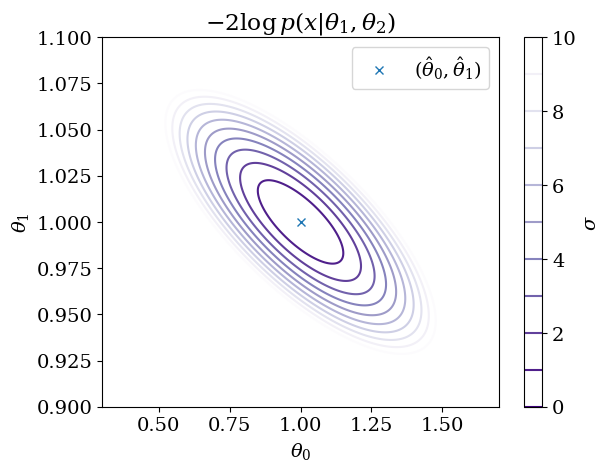

In [204]:
nll_constr = lambda th0, th1: -2*np.log(likelihood(th0, th1, x, y))-2*np.log(prior(th0, th1))
plot_2d_pdf_contour(nll_constr)

In [233]:
sp.optimize.least_squares(lambda th0: nll_constr(*th0,1)-1, [1.])

     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [ 2.614e-10]
           x: [ 1.100e+00]
        cost: 3.4177637760342565e-20
         jac: [[ 2.000e+01]]
        grad: [ 5.229e-09]
  optimality: 5.228968797955804e-09
 active_mask: [ 0.000e+00]
        nfev: 8
        njev: 6

In [192]:
# Metropolis-Hastings Algorithm
def metropolis_hastings(iterations, initial, proposal_std, x, y):
    samples = [initial]
    current = initial
    
    for _ in range(iterations):
        # Propose new candidate
        proposal = np.random.normal(loc=current, scale=proposal_std, size=2)
        
        # Compute acceptance ratio
        p_current = posterior(current[0], current[1], x, y)
        p_proposal = posterior(proposal[0], proposal[1], x, y)
        alpha = min(1, p_proposal / p_current)
        
        # Accept/reject step
        if np.random.rand() < alpha:
            current = proposal  # Accept proposal
        
        samples.append(current)
    
    return np.array(samples)

# Parameters for MCMC
iterations = 500000
initial = [1, 1]  # Starting values for [theta0, theta1]
proposal_std = [0.5, 0.5]  # Standard deviation of proposal distribution

# Run Metropolis-Hastings
samples = metropolis_hastings(iterations, initial, proposal_std, x, y)

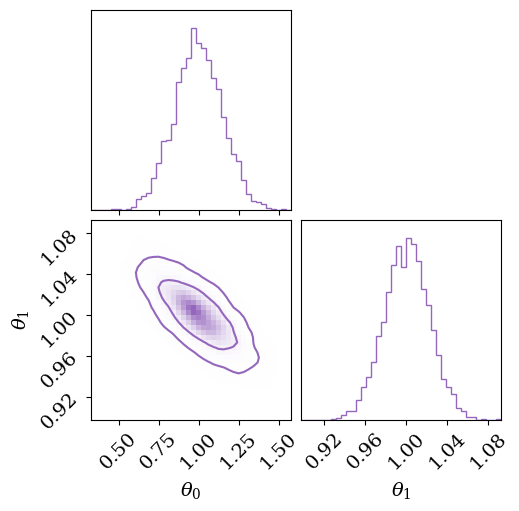

In [193]:
corner.corner(
    samples,
    bins=40,
    levels=(0.68, 0.95),
    smooth=1.0,
    plot_datapoints=False,
    labels=[r'$\theta_0$', r'$\theta_1$'],
    color='tab:purple',
    );

In [194]:
# Random initial values for each chain
initial_points = [
    [np.random.uniform(0, 2), np.random.uniform(0, 2)] for _ in range(8)
]

# Run Metropolis-Hastings for each chain
chains = []
for i, initial in enumerate(initial_points):
    print(f"Running chain {i+1} with initial point {initial}")
    chain = metropolis_hastings(iterations, initial, proposal_std, x, y)
    chains.append(chain)

# Combine all chains
all_samples = np.vstack(chains)

Running chain 1 with initial point [0.21996028974996662, 1.8743645168653336]


/tmp/ipykernel_53727/4178643357.py:13: RuntimeWarning: invalid value encountered in scalar divide
  alpha = min(1, p_proposal / p_current)
/tmp/ipykernel_53727/4178643357.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = min(1, p_proposal / p_current)


Running chain 2 with initial point [0.6840787600938627, 1.1246077401638905]
Running chain 3 with initial point [0.5227108841622476, 0.9807270236404391]
Running chain 4 with initial point [0.05025234217994945, 1.2133971768819654]
Running chain 5 with initial point [0.8432766441899993, 0.3465839676326967]
Running chain 6 with initial point [0.5764743543798005, 1.9807757865519489]
Running chain 7 with initial point [1.8262241485402766, 1.8798112635201847]
Running chain 8 with initial point [0.6336697226553036, 1.7471015233781084]


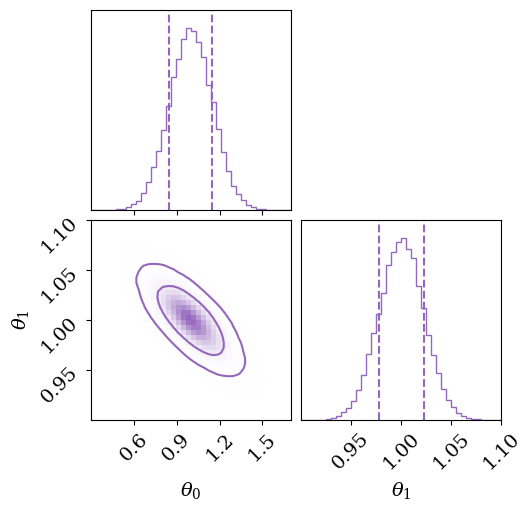

In [195]:
corner.corner(
    all_samples,
    bins=40,
    range=[(0.3,1.7), (0.9,1.1)],
    levels=(0.68, 0.95),
    quantiles=(0.16, 0.84),
    smooth=1.0,
    plot_datapoints=False,
    labels=[r'$\theta_0$', r'$\theta_1$'],
    color='tab:purple',
    );

In [203]:
np.mean(samples[:,0]), np.std(samples[:,0])

(np.float64(0.9962171045900566), np.float64(0.15012767804943683))

In [243]:
(np.abs(samples[:,1]-1)<0.01).sum()

np.int64(174215)

In [244]:
np.mean(samples[np.abs(samples[:,1]-1)<0.01][:,0]), np.std(samples[np.abs(samples[:,1]-1)<0.01][:,0])

(np.float64(0.9973734688689738), np.float64(0.10293392877242134))